# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    - Контролировать добросовестность кассиров при продаже алкоголя.
    
Необходимо постоить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

Определим размер выборки.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


У нас имеется 7591 изображение. Построим гистограмму распределения возраста по фотографиям.

Text(0, 0.5, 'Количество изображений, шт')

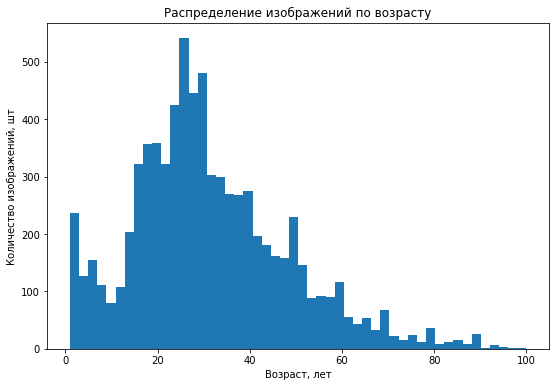

In [3]:
labels['real_age'].sort_values().plot(x='real_age', kind='hist', bins=50, figsize=(9, 6))
plt.title('Распределение изображений по возрасту')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество изображений, шт')

Гистограмма показывает, что распределение возраста было близко к нормальному, если бы не 2 пика по количеству фотографий в районе 5-7 лет и 25 лет. Количество изображений увеличивается с возрастом вплоть до 25-30 лет, а дальше все время снижается. Таким образом наша модель почти не "увидит" изображения лиц людей старше 80 лет, но это не страшно, так как вероятность встретить таких людей ниже, чем более молодых.

Проверим на каких изображениях будет обучатся модель.

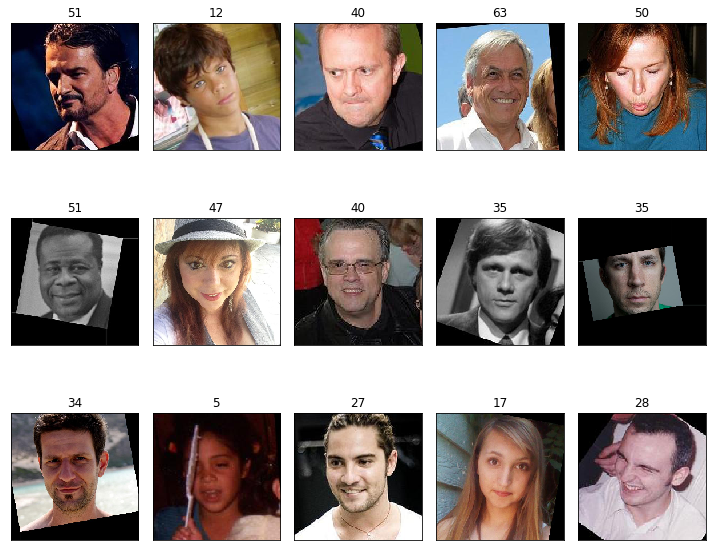

In [5]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

В этом разделе был проведен исследовательский анализ данных, выяснилось, что модель будет обучатся на 7591 изображении. Кроме того было построено распределение людей на этих фотографиях по их возрасту и оказалось, что распределение напоминает по виду нормальное, правда кроме основного пика количества изображений в районе 25-30 лет имеется побочный пик слева в районе 5-7 лет. Количество фотографий людей от 80 и выше близко к нулю.

## Обучение модели

Код для обучения модели:

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
 
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25)   
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    return train_gen_flow
 
def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)  
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + '/labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_gen_flow
 
 
def create_model(input_shape):
    optimizer = Adam(lr=0.001)
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(80, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='relu')) 
 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model 

```

Вывод:

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 93s - loss: 231.4818 - mae: 11.7035 - val_loss: 326.4561 - val_mae: 14.9320
Epoch 2/10
178/178 - 41s - loss: 150.0814 - mae: 9.4164 - val_loss: 289.8454 - val_mae: 12.8000
Epoch 3/10
178/178 - 41s - loss: 115.6140 - mae: 8.2237 - val_loss: 332.8730 - val_mae: 13.4857
Epoch 4/10
178/178 - 41s - loss: 87.2505 - mae: 7.1413 - val_loss: 315.0415 - val_mae: 13.1198
Epoch 5/10
178/178 - 40s - loss: 61.4276 - mae: 6.0621 - val_loss: 158.7535 - val_mae: 9.8357
Epoch 6/10
178/178 - 41s - loss: 45.6077 - mae: 5.2087 - val_loss: 145.6640 - val_mae: 8.9617
Epoch 7/10
178/178 - 41s - loss: 31.8911 - mae: 4.3989 - val_loss: 103.6818 - val_mae: 7.6346
Epoch 8/10
178/178 - 40s - loss: 25.7444 - mae: 3.9323 - val_loss: 96.5891 - val_mae: 7.4681
Epoch 9/10
178/178 - 41s - loss: 21.5961 - mae: 3.5832 - val_loss: 120.3967 - val_mae: 8.1541
Epoch 10/10
178/178 - 40s - loss: 17.7838 - mae: 3.2517 - val_loss: 91.8293 - val_mae: 7.3707

60/60 - 10s - loss: 91.8293 - mae: 7.3707
Test MAE: 7.3707

```

## Анализ обученной модели

Как было написано в первом разделе: выяснилось, что модель будет обучатся на 7591 изображении. Кроме того было построено распределение людей на этих фотографиях по их возрасту и оказалось, что распределение напоминает по виду нормальное, правда кроме основного пика количества изображений в районе 25-30 лет имеется побочный пик слева в районе 5-7 лет. Количество фотографий людей от 80 и выше близко к нулю.

Сама модель на основе ResNet50 была обучена метрика качества МАЕ на 10 эпохе на тестовой выборке опустилась до 7.37, что можно считать успехом. Тем не менее модель сильно переобучилась (значние МАЕ на тренировочной выборке на 10 эпохе 3.25), но для нейросетей такие показатели нормальны.

Низкое значение метрики МАЕ говорит о том, что модель подходит для внедрения для решение бизнес задач.